Inspiration: 
https://medium.com/mlearning-ai/time-series-forecasting-with-xgboost-and-lightgbm-predicting-energy-consumption-460b675a9cee

Vorgehen:
https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html


10000 Variablen: 
- Sonst HistGradientBoost besser, allerdings keine Quantile Forecasts

In [1]:
# Use same amount of data --> In the end: to general, only consider last 3 months
2.5*265*24

15900.0

In [1]:
# use latest data points
from energy_consumption.feature_selection.extract.extract_energy_data import get_data
energydata = get_data(num_years = 2)

100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


In [2]:
energydata = energydata.reset_index()

In [3]:
energydata["hour"] = energydata["date_time"].dt.hour                         # new
energydata["day_of_week"] = energydata["date_time"].dt.dayofweek
#energydata["day_of_year"] = energydata["date_time"].dt.dayofyear             # quite similar to index-proposal
#energydata["month"] = energydata["date_time"].dt.month
# energydata["quarter"] = energydata["date_time"].dt.quarter                 # not important
energydata['weekly_lag'] = energydata['energy_consumption'].shift(168)       # proposal video call
energydata['yearly_lag'] = energydata['energy_consumption'].shift(8760)
energydata = energydata.set_index('date_time')
#energydata = energydata.drop(columns=['year'])                               # no need to drop if conducted from scratch

In [9]:
energydata[-8765:]

,energy_consumption,hour,day_of_week,weekly_lag,yearly_lag
date_time,,,,,
2023-01-24 08:00:00,65.10775,8,1,69.13900,NaN
2023-01-24 09:00:00,66.12950,9,1,69.14450,NaN
2023-01-24 10:00:00,67.10875,10,1,69.26875,NaN
2023-01-24 11:00:00,67.88475,11,1,69.69400,NaN
2023-01-24 12:00:00,67.82975,12,1,69.06900,NaN
...,...,...,...,...,...
2024-01-24 08:00:00,71.52975,8,2,72.40200,65.10775
2024-01-24 09:00:00,71.68775,9,2,73.08200,66.12950
2024-01-24 10:00:00,72.02475,10,2,72.98150,67.10875


In [10]:
# one quarter
24*30*3

2160

In [4]:
energydata = energydata[-2160:].copy()
energydata['index'] = range(1, len(energydata) + 1)

training_data = energydata[:-168]
testing_data = energydata[-168:]

In [5]:
X_train = training_data.drop(columns=['energy_consumption'])
X_test = testing_data.drop(columns=['energy_consumption'])

y_train = training_data[['energy_consumption']]
y_test = testing_data[['energy_consumption']]

Hyperparameter Tuning: 
* Commonly used methods: GridSearchCV or RandomizedSearchCV 
* scikit-learnscikit-learn's current version doesn't directly support quantile regression as a loss function in its grid search
--> create custom scorer for quantile loss and use (here) RandomizedSearchCV

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Define the quantile loss function as a scorer
def quantile_loss_scorer(y_true, y_pred, alpha):
    l_score = []
    errors = y_true - y_pred

    for i in range(len(errors)):
        if errors[i] > 0:
            l_score.append(2 * (1 - alpha) * errors[i])
        else:
            l_score.append(2 * alpha * (-errors[i]))

    return np.mean(l_score)

# Define the parameter grid to search over
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 500, 700],
    'max_depth': [3, 4, 5, 6, 10],                       # max should be between 8 and 12
    'min_samples_leaf': list(range(5, 15)),
    'min_samples_split': list(range(5, 15))
}

# Create the time series split
tscv = TimeSeriesSplit(n_splits=4, test_size=100)
best_parameters = {}

for alpha in [0.025, 0.25, 0.5, 0.75, 0.975]:

    # Create a custom scorer for quantile loss
    quantile_scorer = make_scorer(
        quantile_loss_scorer, greater_is_better=False, alpha=alpha)

    # Create the GradientBoostingRegressor model
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha)

    # Create the RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        gbr,
        param_distributions=param_grid,
        scoring=quantile_scorer,
        cv=tscv,
        n_iter=15,    #keep low bc. of computational resources                           
        random_state=42,
        verbose=1
    )

    # Fit the model
    random_search.fit(X_train, y_train.values.ravel())

    # Get the best hyperparameters
    best_params = random_search.best_params_

    print(f"Best Hyperparameters for {alpha}", best_params)
    best_parameters.update({alpha: best_params})

Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best Hyperparameters for 0.025 {'n_estimators': 700, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_depth': 5, 'learning_rate': 0.3}
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best Hyperparameters for 0.25 {'n_estimators': 300, 'min_samples_split': 9, 'min_samples_leaf': 11, 'max_depth': 4, 'learning_rate': 0.2}
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best Hyperparameters for 0.5 {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 4, 'learning_rate': 0.1}
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best Hyperparameters for 0.75 {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 4, 'learning_rate': 0.1}
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best Hyperparameters for 0.975 {'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_depth': 5, 'learning_rate': 0.3}


## Model with selected parameters 

In [6]:
import pandas as pd
from sklearn.metrics import mean_pinball_loss
from sklearn.ensemble import GradientBoostingRegressor

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
quantile_params = {}

for alpha in quantiles:
    # set hyperparameters based on the best results for each alpha/ ensure corresponding alphas for forecast are in right interval
    if alpha <= 0.1:
        params = dict({'n_estimators': 700, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_depth': 5, 'learning_rate': 0.3})
    elif alpha <= 0.35:
        params = dict({'n_estimators': 300, 'min_samples_split': 9, 'min_samples_leaf': 11, 'max_depth': 4, 'learning_rate': 0.2})
    elif alpha <= 0.65:
        params = dict({'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 4, 'learning_rate': 0.1})
    elif alpha < 0.9:
        params = dict({'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 4, 'learning_rate': 0.1})
    elif alpha >= 0.9:
        params = dict({'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_depth': 5, 'learning_rate': 0.3})

    quantile_params[alpha] = params

predictions = pd.DataFrame()
pinball_losses = {}

for alpha, params in quantile_params.items():
    name = f'q{alpha}'
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **params)
    quantile_model = gbr.fit(X_train, y_train)
    y_pred = quantile_model.predict(X_test)

    predictions[name] = y_pred
    pinball_losses.update(
        {name: mean_pinball_loss(y_test, y_pred, alpha=alpha)})

c:\Users\Maria\Documents\Setups\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Maria\Documents\Setups\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Maria\Documents\Setups\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Maria\Documents\Setups\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

In [7]:
import numpy as np
predictions['obs'] = np.array(y_test[['energy_consumption']])
predictions['date_time'] = y_test.index
predictions


,q0.025,q0.25,q0.5,q0.75,q0.975,obs,date_time
0,68.547304,70.773151,71.384550,71.447079,71.908796,71.60325,2024-01-17 13:00:00
1,67.633938,69.722879,70.006964,69.767100,71.812489,70.62675,2024-01-17 14:00:00
2,67.137199,68.694503,69.540779,69.416295,70.976509,69.26850,2024-01-17 15:00:00
3,67.012495,68.846659,69.619905,70.005548,71.629342,69.43150,2024-01-17 16:00:00
4,69.095909,70.472934,70.922070,71.431911,72.133048,71.15625,2024-01-17 17:00:00
...,...,...,...,...,...,...,...
163,65.983279,70.335608,70.942755,71.846470,72.873207,71.52975,2024-01-24 08:00:00
164,67.204523,71.353271,71.636947,72.201274,72.863954,71.68775,2024-01-24 09:00:00
165,67.406787,71.899355,71.833053,72.359612,72.872796,72.02475,2024-01-24 10:00:00
166,67.473132,72.382540,72.282714,72.783962,72.774455,73.12275,2024-01-24 11:00:00


In [14]:
import pandas as pd

# Your DataFrame
df = predictions

# Define the quantiles columns
quantile_cols = [f'q{q}' for q in quantiles]
quantile_cols

# Loop through the quantiles
for i in range(len(quantile_cols) - 1):
    current_quantile = quantile_cols[i]
    next_quantile = quantile_cols[i + 1]

    # Check if there is an overlap
    overlap = df[current_quantile] > df[next_quantile]

    # Adjust the values if there is an overlap
    df.loc[overlap, next_quantile] = df[current_quantile][overlap]

# Display the adjusted DataFrame
df

,q0.025,q0.25,q0.5,q0.75,q0.975,obs,date_time
0,69.260289,70.240629,70.879194,71.403292,72.295734,71.60325,2024-01-17 13:00:00
1,67.966895,70.000383,70.000383,70.000383,72.121469,70.62675,2024-01-17 14:00:00
2,67.137492,68.740744,68.834671,69.149921,71.428300,69.26850,2024-01-17 15:00:00
3,67.340446,68.310372,68.907404,69.829438,72.119811,69.43150,2024-01-17 16:00:00
4,69.876259,70.202773,70.605778,70.976306,72.262580,71.15625,2024-01-17 17:00:00
...,...,...,...,...,...,...,...
163,68.193426,70.483277,70.877863,71.585861,73.147982,71.52975,2024-01-24 08:00:00
164,68.506144,71.179289,71.300819,72.049712,73.144646,71.68775,2024-01-24 09:00:00
165,69.685680,71.661141,71.661141,72.160023,73.144646,72.02475,2024-01-24 10:00:00
166,69.626103,72.243204,72.243204,72.744841,73.180791,73.12275,2024-01-24 11:00:00


In [9]:
pinball_losses

{'q0.025': 0.49953346804668797,
 'q0.25': 0.9191413630411527,
 'q0.5': 0.7770781991168496,
 'q0.75': 0.5642612133370692,
 'q0.975': 0.1671074764857725}

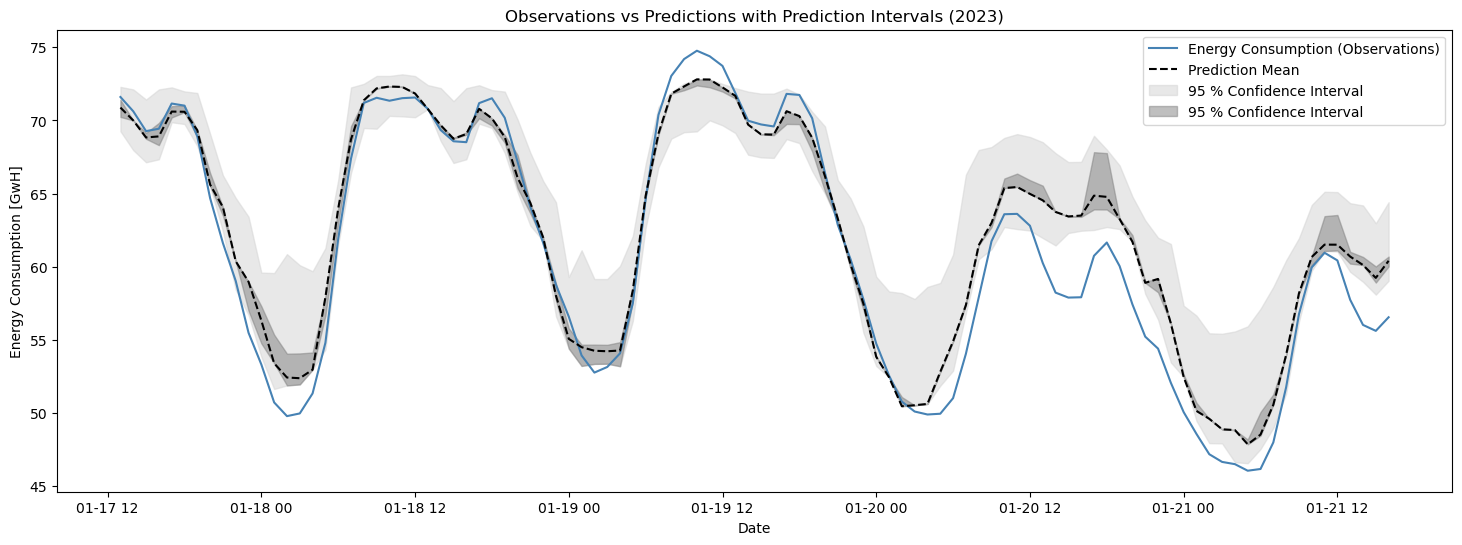

In [16]:
import matplotlib.pyplot as plt

# Convert 'date_time' to datetime
df['date_time'] = pd.to_datetime(df['date_time'])

# Select the first 100 observations
subset_predictions = df.head(100)

# Plot the observations
plt.figure(figsize=(18, 6))
plt.plot(subset_predictions['date_time'],
         subset_predictions['obs'], label='Energy Consumption (Observations)', color='steelblue')

# Plot the prediction mean
plt.plot(subset_predictions['date_time'],
         subset_predictions['q0.5'], label='Prediction Mean', color='black', linestyle='--')

# Fill between quantiles for prediction intervals
plt.fill_between(subset_predictions['date_time'], subset_predictions['q0.025'],
                 subset_predictions['q0.975'], color='lightgray', alpha=0.5, label='95 % Confidence Interval')

# Fill between quantiles for prediction intervals
plt.fill_between(subset_predictions['date_time'], subset_predictions['q0.25'],
                 subset_predictions['q0.75'], color='gray', alpha=0.5, label='95 % Confidence Interval')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Energy Consumption [GwH]')
plt.title(
    'Observations vs Predictions with Prediction Intervals (2023)')
plt.legend()

# Show the plot
plt.show()

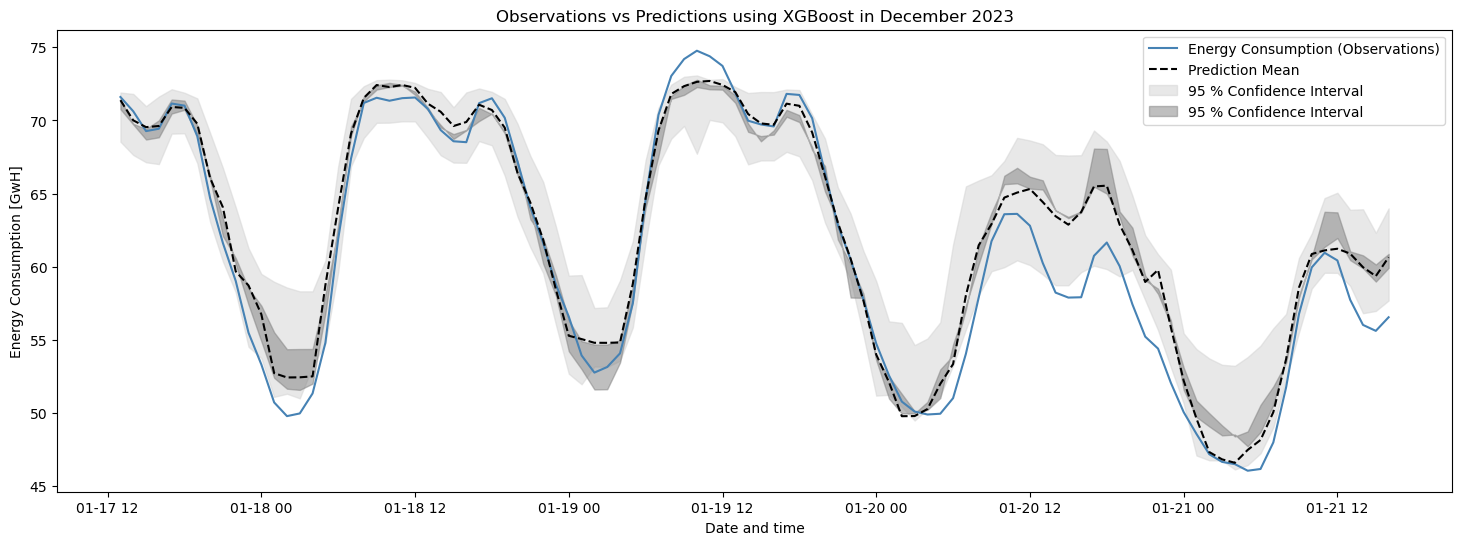

In [10]:
import matplotlib.pyplot as plt

# Convert 'date_time' to datetime
predictions['date_time'] = pd.to_datetime(predictions['date_time'])

# Select the first 100 observations
subset_predictions = predictions.head(100)

# Plot the observations
plt.figure(figsize=(18, 6))
plt.plot(subset_predictions['date_time'],
         subset_predictions['obs'], label='Energy Consumption (Observations)', color='steelblue')

# Plot the prediction mean
plt.plot(subset_predictions['date_time'],
         subset_predictions['q0.5'], label='Prediction Mean', color='black', linestyle='--')

# Fill between quantiles for prediction intervals
plt.fill_between(subset_predictions['date_time'], subset_predictions['q0.025'],
                 subset_predictions['q0.975'], color='lightgray', alpha=0.5, label='95 % Confidence Interval')

# Fill between quantiles for prediction intervals
plt.fill_between(subset_predictions['date_time'], subset_predictions['q0.25'],
                 subset_predictions['q0.75'], color='gray', alpha=0.5, label='95 % Confidence Interval')

# Add labels and legend
plt.xlabel('Date and time')
plt.ylabel('Energy Consumption [GwH]')
plt.title(
    'Observations vs Predictions using XGBoost in December 2023')
plt.legend()

# Show the plot
plt.show()

Interpretation: probably a pretty cruicial time, since christmas --> fits way better to hours now
However: hourly and weekly seasonalities pretty good incorporated now

In [1]:
import pandas as pd
energydata = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata['date_time'] = pd.to_datetime(
    energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
energydata = energydata.set_index("date_time")
energydata = energydata[-10000:]
energydata

,energy_consumption
date_time,
2022-10-01 21:00:00,49.12975
2022-10-01 22:00:00,46.88900
2022-10-01 23:00:00,44.06500
2022-10-02 00:00:00,41.74750
2022-10-02 01:00:00,40.16575
...,...
2023-11-22 08:00:00,65.75125
2023-11-22 09:00:00,67.40950
2023-11-22 10:00:00,68.26775


In [50]:
10000/(365*24)

1.1415525114155252

In [51]:
from energy_consumption.feature_selection.extract import extract_energy_data
energydata = extract_energy_data.get_data(num_years=2)

100%|██████████| 104/104 [01:17<00:00,  1.35it/s]


In [52]:
from energy_consumption.help_functions import get_forecast_timestamps

def get_energy_and_forecast(energydata): 
    
    energydf = energydata.copy()
    energyforecast = get_forecast_timestamps.forecast_timestamps(
        energydf.index[-1])
    energyforecast['energy_consumption'] = np.nan
    merged = pd.concat([energydf, energyforecast]).reset_index()

    merged["hour"] = merged["date_time"].dt.hour
    merged["day_of_week"] = merged["date_time"].dt.dayofweek
    merged['weekly_lag'] = merged['energy_consumption'].shift(168)
    merged['yearly_lag'] = merged['energy_consumption'].shift(8760)
    merged = merged[-2260:]
    merged['index'] = range(1, len(merged) + 1)
    merged = merged.set_index('date_time')

    energydf = merged[-2260:-100]
    energyforecast = merged[-100:].drop(columns=['energy_consumption'])
    
    return energydf, energyforecast

In [56]:
e, d = get_energy_and_forecast(energydata)
d

,hour,day_of_week,weekly_lag,yearly_lag,index
date_time,,,,,
2024-01-24 13:00:00,13,2,71.60325,67.34300,2161
2024-01-24 14:00:00,14,2,70.62675,66.03550,2162
2024-01-24 15:00:00,15,2,69.26850,65.06650,2163
2024-01-24 16:00:00,16,2,69.43150,64.33225,2164
2024-01-24 17:00:00,17,2,71.15625,66.13675,2165
...,...,...,...,...,...
2024-01-28 12:00:00,12,6,60.42075,58.29350,2256
2024-01-28 13:00:00,13,6,57.72625,57.28550,2257
2024-01-28 14:00:00,14,6,56.00725,56.34450,2258


In [57]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions.drop_years import drop_years
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame

def get_opt_parameters(quantiles): 

    quantile_params = dict()

    for alpha in quantiles:
        # set hyperparameters based on the best results for each alpha
        if alpha <= 0.1:
            params = dict({'n_estimators': 700, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_depth': 5, 'learning_rate': 0.3})
        elif alpha <= 0.35:
            params = dict({'n_estimators': 300, 'min_samples_split': 9, 'min_samples_leaf': 11, 'max_depth': 4, 'learning_rate': 0.2})
        elif alpha <= 0.65:
            params = dict({'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 4, 'learning_rate': 0.1})
        elif alpha < 0.9:
            params = dict({'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 4, 'learning_rate': 0.1})
        elif alpha >= 0.9:
            params = dict({'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_depth': 5, 'learning_rate': 0.3})

        quantile_params[alpha] = params

    return quantile_params


def get_XGBoost_forecasts(energydata=np.nan, indexes=[47, 51, 55, 71, 75, 79], quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], periods=100, abs_eval = False):

    if type(energydata) == float:
        energydata = extract_energy_data.get_data(num_years=2) 
    
    energydata, X_pred = get_energy_and_forecast(energydata)

    X = energydata.drop(columns=['energy_consumption'])
    y = energydata['energy_consumption']

    quantile_df = pd.DataFrame()
    quantile_params = get_opt_parameters(quantiles)
    
    for alpha in quantiles:
        name = f'q{alpha}'
        opt_params = quantile_params[alpha]
        gbr = GradientBoostingRegressor(
            loss="quantile", alpha=alpha, **opt_params)
        quantile_model = gbr.fit(X, y)
        y_pred = quantile_model.predict(X_pred)
        quantile_df[name] = y_pred

    quantile_df = quantile_df.iloc[indexes]

    # return quantile forecasts in terms of absolute evaluation
    if abs_eval == True:
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        quantile_df.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return quantile_df

    # else: create submission frame
    else:
        forecast_frame = create_submission_frame.get_frame(
            quantile_df, indexes)
        forecast_frame = forecast_frame.drop(columns={'index'})
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        forecast_frame.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return forecast_frame

In [6]:
energydata = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata['date_time'] = pd.to_datetime(
    energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
energydata = energydata.set_index("date_time")

In [ ]:
forecasts = get_XGBoost_forecasts(energydata, indexes=list(range(20)), quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], abs_eval=True)
forecasts

Maybe: Try out different parameters

Forecast Calibration

In [59]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
 'q0.7', 'q0.8', 'q0.9', 'energy_consumption'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# exactly 8 weekly rounds from energydata_hist to new data 
for i in range(1, 8):
    print(f'start of round {i}') 
    forecasts = get_XGBoost_forecasts(energydata[:i*(-168)], 
                                      indexes=list(range(100)), 
                                      quantiles=quantiles, abs_eval=True)
    obs = energydata[i*(-168):i*(-168)+100].reset_index()
    forecasts_obs = forecasts.merge(obs, how='left', on='date_time')
    pit_merged = pd.concat([pit_merged, forecasts_obs])

start of round 1
start of round 2
start of round 3
start of round 4
start of round 5
start of round 6
start of round 7


In [60]:
column_index = pit_merged.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged.columns:
    pit_merged.insert(column_index, 'q1', float('inf'))
pit_merged

,date_time,q0.1,q0.2,q0.3,q0.4,q0.5,q0.6,q0.7,q0.8,q0.9,q1,energy_consumption
0,2024-01-17 13:00:00,71.099283,70.533086,69.960328,70.771404,70.949014,70.915297,71.675250,71.271414,71.483217,inf,71.60325
1,2024-01-17 14:00:00,68.250096,69.090646,69.202080,69.361444,70.143235,69.625462,70.482447,69.861813,69.972575,inf,70.62675
2,2024-01-17 15:00:00,67.940548,67.375602,68.310803,68.844547,69.389154,68.271959,69.188096,69.790559,69.209340,inf,69.26850
3,2024-01-17 16:00:00,68.015475,67.289311,68.665229,68.878820,69.576059,68.326441,70.053574,69.662485,68.742681,inf,69.43150
4,2024-01-17 17:00:00,71.498393,69.480531,69.981699,70.155077,70.924553,70.666079,71.227739,71.154531,71.538896,inf,71.15625
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2023-12-10 12:00:00,55.278678,56.786947,57.005258,57.245217,57.247372,56.142085,57.033140,55.954631,56.457781,inf,55.40900
96,2023-12-10 13:00:00,53.232862,55.279825,55.159934,55.339180,55.438440,53.753078,53.406213,54.672301,54.413110,inf,53.57775
97,2023-12-10 14:00:00,53.126790,54.564834,54.250260,54.520165,54.694598,53.013215,52.961138,53.897022,53.759184,inf,52.50025
98,2023-12-10 15:00:00,53.171000,54.622435,54.298699,54.520165,54.695093,53.181795,52.992576,54.726386,53.860558,inf,52.27550


In [61]:
import matplotlib.pyplot as plt

def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'

# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()


quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else:
        ordered_quantile_counts[q] = 0

counts = list(ordered_quantile_counts.values())
ordered_quantile_counts

{0.1: 238,
 0.2: 122,
 0.3: 52,
 0.4: 56,
 0.5: 24,
 0.6: 17,
 0.7: 33,
 0.8: 20,
 0.9: 32,
 1: 106}

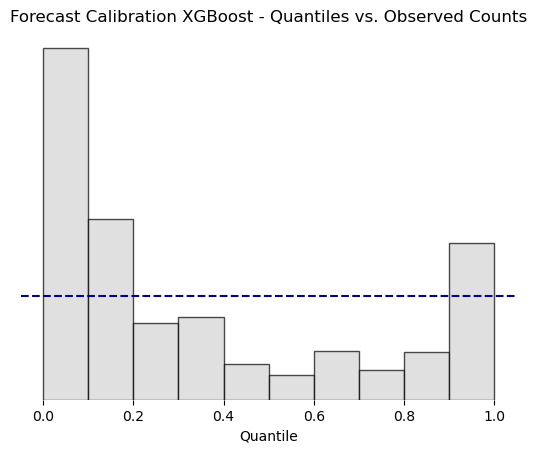

In [62]:
import matplotlib.pyplot as plt

bar_width = 0.1

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Calculate the mean of the y-values
mean_value = sum(counts) / len(counts)

# Centering the bars on the left-hand side of their ticks
plt.bar([q - bar_width for q in quantiles], counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])

 # Plot mean
plt.axhline(y=mean_value, color='darkblue', linestyle='--', label='Mean')


# Alternatively: observed counts in each quantile range
plt.title('Forecast Calibration XGBoost - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()